In [32]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from matplotlib import animation, rc
#from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
#import pandas as pd
import geopandas as gpd
import rioxarray
#from shapely.geometry import mapping
from eofs.xarray import Eof
from xeofs.xarray import EOF
#from xarrayutils.utils import linear_trend
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt

### File Paths

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
%%time
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

CPU times: user 13.5 ms, sys: 4.33 ms, total: 17.8 ms
Wall time: 20.7 ms


In [5]:
%%time
reconstr_full = xr.open_dataset(inDirName+interim_data_folder+'reconstructed_flux_all_modes.nc')
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

CPU times: user 13.1 ms, sys: 6.12 ms, total: 19.2 ms
Wall time: 18.6 ms


In [30]:
def clip_data(total_data, basin):
    #with rioxarray.set_options(export_grid_mapping=False):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'])
    clipped_data = clipped_data.dropna('time',how='all')
    clipped_data = clipped_data.dropna('y',how='all')
    clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [8]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

CPU times: user 3.56 s, sys: 10.1 s, total: 13.7 s
Wall time: 17.1 s


Text(0.5, 1.0, 'PSD Comparison: Filchner-Ronne')

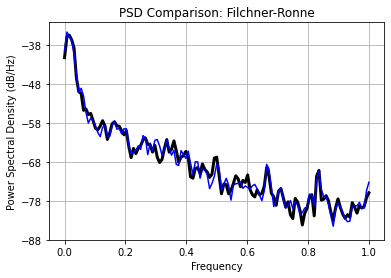

In [17]:
%%time
basin = 0
orig_basin = clip_data(flux_clean, basin)
rec_basin = clip_data(flux_reconstr, basin)
orig_basin_ts = time_series(orig_basin)
rec_basin_ts = time_series(rec_basin)
plt.psd(orig_basin_ts,label='Original', linewidth=3, color='k');
plt.psd(rec_basin_ts, color = 'b');
plt.title('PSD Comparison: {}'.format(icems.name.values[basin]))

In [28]:
basins = [34,55,104,114]

In [34]:
def psd_calc(time_series):
    psd_arr = plt.psd(time_series)
    return psd_arr

clipped orig_basin..Amery
clipped rec_basin..Amery
calculated time series..Amery
Calculated for basin..Amery
deleting interim variables
clipped orig_basin..Filchner
clipped rec_basin..Filchner
calculated time series..Filchner
Calculated for basin..Filchner
deleting interim variables
clipped orig_basin..Western_Ross
clipped rec_basin..Western_Ross
calculated time series..Western_Ross
Calculated for basin..Western_Ross
deleting interim variables
clipped orig_basin..Thwaites
clipped rec_basin..Thwaites
calculated time series..Thwaites
Calculated for basin..Thwaites
deleting interim variables
CPU times: user 10 s, sys: 30.4 s, total: 40.4 s
Wall time: 49.9 s


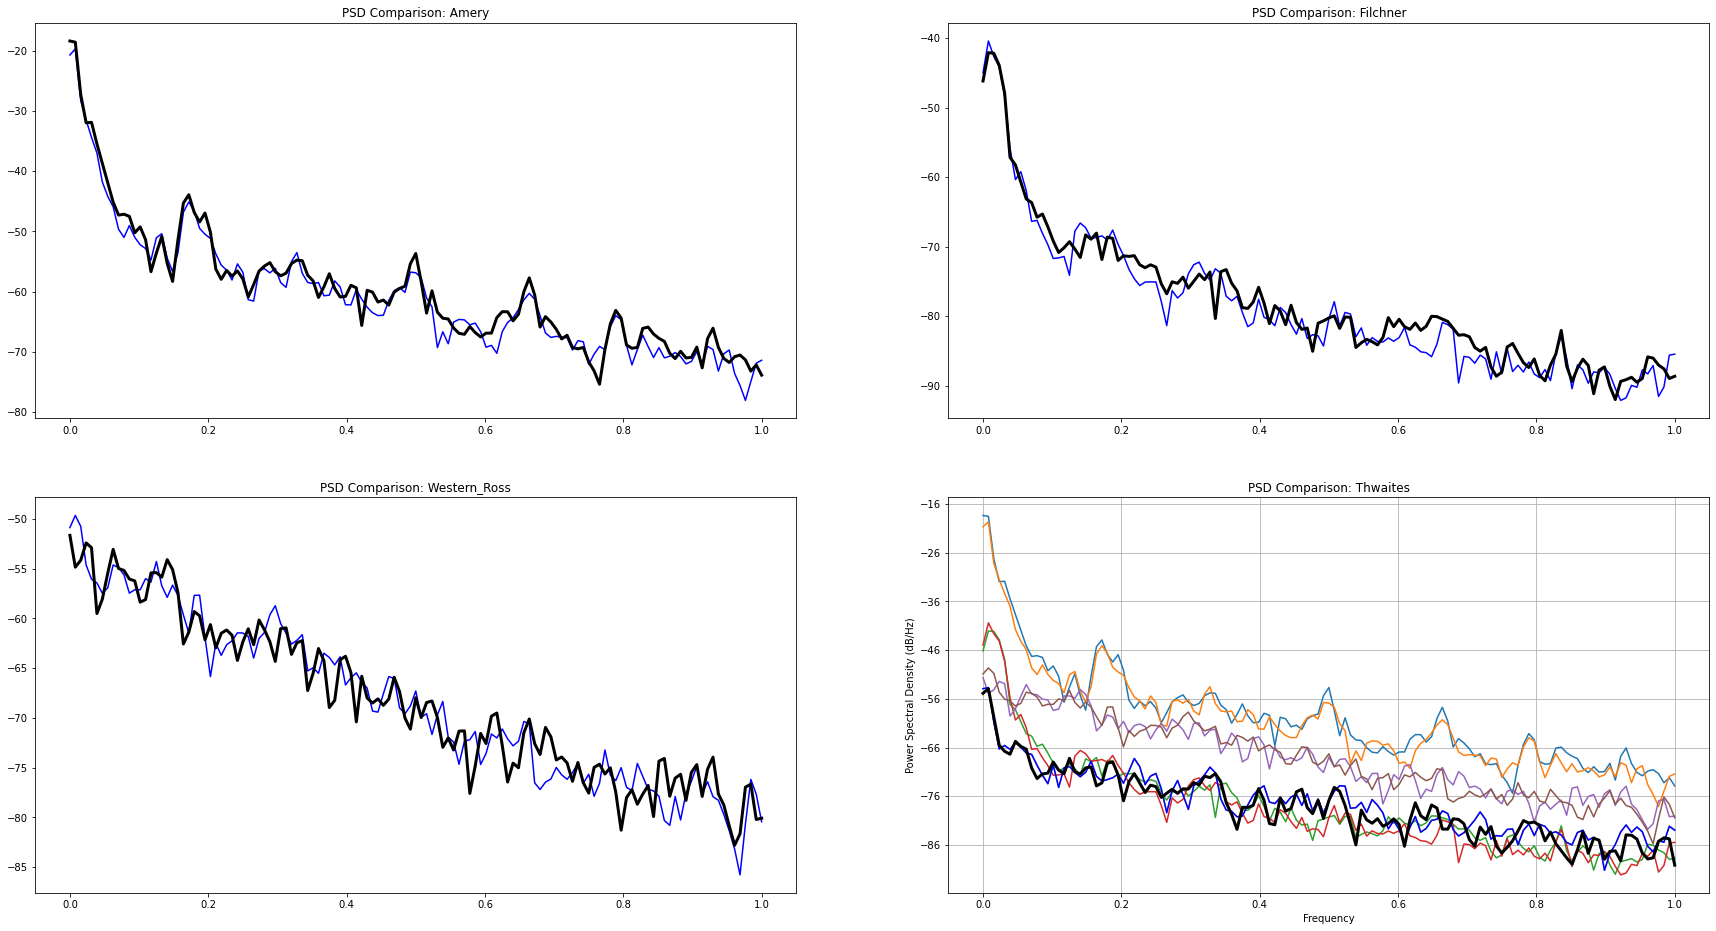

In [37]:
%%time

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()
i=0
for basin in basins:
    orig_basin = clip_data(flux_clean, basin)
    print('clipped orig_basin..{}'.format(icems.name.values[basin]))
    rec_basin = clip_data(flux_reconstr, basin)
    print('clipped rec_basin..{}'.format(icems.name.values[basin]))
    orig_basin_ts = time_series(orig_basin)
    rec_basin_ts = time_series(rec_basin)
    print('calculated time series..{}'.format(icems.name.values[basin]))
    orig = psd_calc(orig_basin_ts);
    rec = psd_calc(rec_basin_ts);
    axs[i].plot(rec[1], 10*np.log10(rec[0]), color = 'b')
    axs[i].plot(orig[1], 10*np.log10(orig[0]), label='Original', linewidth=3, color='k')
    print('Calculated for basin..{}'.format(icems.name.values[basin]))
    rmse = sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))
    axs[i].set_title('PSD Comparison: {0}'.format(icems.name.values[basin]))
    del orig_basin, rec_basin, orig_basin_ts, rec_basin_ts, orig, rec, rmse
    print('deleting interim variables')
    gc.collect()
    i=i+1

In [16]:
#calculate RMSE
sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))

['Filchner-Ronne' 'Ross' 'Antarctica' 'Peninsula' 'West Antarctica'
 'East Antarctica' 'IMBIE1' 'IMBIE2' 'IMBIE3' 'IMBIE4' 'IMBIE5' 'IMBIE6'
 'IMBIE7' 'IMBIE8' 'IMBIE9' 'IMBIE10' 'IMBIE11' 'IMBIE12' 'IMBIE13'
 'IMBIE14' 'IMBIE15' 'IMBIE16' 'IMBIE17' 'IMBIE18' 'IMBIE19' 'IMBIE20'
 'IMBIE21' 'IMBIE22' 'IMBIE23' 'IMBIE24' 'IMBIE25' 'IMBIE26' 'IMBIE27'
 'Abbot' 'Amery' 'Atka' 'Aviator' 'Bach' 'Baudouin' 'Borchgrevink'
 'Brahms' 'Brunt_Stancomb' 'Campbell' 'Cheetham' 'Conger_Glenzer' 'Cook'
 'Cosgrove' 'Crosson' 'Dennistoun' 'Dibble' 'Dotson' 'Drygalski'
 'Edward_VIII' 'Ekstrom' 'Ferrigno' 'Filchner' 'Fimbul' 'Fitzgerald'
 'Frost' 'GeikieInlet' 'George_VI' 'Getz' 'Gillet' 'Hamilton' 'Hannan'
 'HarbordGlacier' 'Helen' 'Holmes' 'HolmesWest' 'Hull' 'Jelbart' 'Land'
 'Larsen_B' 'Larsen_C' 'Larsen_D' 'Larsen_E' 'Larsen_F' 'Larsen_G'
 'Lazarev' 'Lillie' 'Mariner' 'Matusevitch' 'Mendelssohn' 'Mertz'
 'Moscow_University' 'Moubray' 'Mulebreen' 'Myers' 'Nansen' 'Nickerson'
 'Ninnis' 'Nivl' 'Noll' 'No